In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# download basic hero stats that we can use for embedding

_hero_embedding_query = "https://api.opendota.com/api/heroStats?api_key="
resp = requests.get(_hero_embedding_query)
assert resp.ok
stats = pd.DataFrame(json.loads(resp.content)).set_index("id")

In [3]:
stats.columns

Index(['name', 'localized_name', 'primary_attr', 'attack_type', 'roles', 'img',
       'icon', 'base_health', 'base_health_regen', 'base_mana',
       'base_mana_regen', 'base_armor', 'base_mr', 'base_attack_min',
       'base_attack_max', 'base_str', 'base_agi', 'base_int', 'str_gain',
       'agi_gain', 'int_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'cm_enabled', 'legs',
       'hero_id', 'turbo_picks', 'turbo_wins', 'pro_ban', 'pro_win',
       'pro_pick', '1_pick', '1_win', '2_pick', '2_win', '3_pick', '3_win',
       '4_pick', '4_win', '5_pick', '5_win', '6_pick', '6_win', '7_pick',
       '7_win', '8_pick', '8_win', 'null_pick', 'null_win'],
      dtype='object')

In [4]:
# get roles embedding for each hero
roles_encoding = stats["roles"].str.join("|").str.get_dummies()

# basic embedding: roles + attack_type + primary_attribute
embedding = pd.concat([pd.get_dummies(stats[["attack_type", "primary_attr"]]), roles_encoding], axis = 1)
embedding  # we have our embedding

,attack_type_Melee,attack_type_Ranged,primary_attr_agi,primary_attr_int,primary_attr_str,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
id,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,1,0,0,1,0,0
2,1,0,0,0,1,1,1,1,0,1,1,0,0,0
3,0,1,0,1,0,0,1,1,0,0,0,1,0,1
4,1,0,1,0,0,1,1,0,0,1,1,1,0,0
5,0,1,0,1,0,0,1,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0,1,0,0,1,0,1,0,1,0,0,1,0,1
129,1,0,0,0,1,1,1,1,0,1,0,0,0,0
135,1,0,0,0,1,1,0,1,0,0,0,0,0,0


In [5]:
# load in dataset of drafts match outcomes

dataset = pd.read_pickle("../data/dota.pickle")
radiant_win, radiant_draft, dire_draft, _, _, _, num_heroes = dataset

In [6]:
heroes = np.unique(radiant_draft) # all the heroes in the dataset (assume everyone played on radiant at least once)

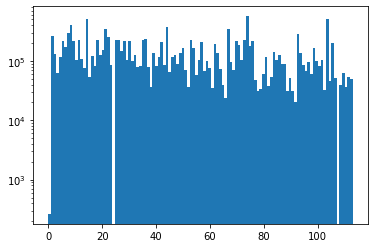

In [7]:
plt.hist(radiant_draft.flatten(), bins=114, log=True)
plt.show()

In [8]:
"""
looks like the dataset is missing hero id 24 (this is a known missing id from the entire DOTA dataset). 
We also have no games where 108 is missing but 109-113 are available - this is because underlord (108)
had an id assigned but was not added until after our dataset was generated, so heroes like arc warden
have a later id but were in the game earlier and therefore in this dataset.

also there is no hero with id 0, so not sure why this is in our dataset - will drop all games in 
which an id of 0 occurs.

=> our dataset is the first 111 heroes released
"""
set(np.arange(114)).difference(set(np.unique(radiant_draft))) 

{24, 108}

In [9]:
games = np.concatenate((radiant_draft, dire_draft), axis=1)
drop_games_with_zero_id = ~(games == 0).any(axis=1)
games = games[drop_games_with_zero_id]
radiant_win = radiant_win[drop_games_with_zero_id]

assert games.shape[0] == radiant_win.shape[0]

In [10]:
heroes_id = np.unique(games)
heroes_id

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 109, 110, 111, 112, 113], dtype=int64)

In [11]:
NUM_HEROES = len(heroes_id)
NUM_MATCHES = len(games)

hero_id_to_index_mapping = {val: idx for idx, val in enumerate(heroes_id)}  # map each hero to an index position for the vector encoding
embedding = embedding.loc[heroes_id]
assert len(embedding) == NUM_HEROES

# build the draft vector described in paper, a (num_heroes x 1) vector with +1 in the ith entry if the ith hero is picked by radiant, -1 if picked by the dire, 0 otherwise.
drafts = list()
empty_draft = np.zeros((NUM_HEROES,))

# game the hero ids to their correct vector encoding positions
mapped_games = np.vectorize(hero_id_to_index_mapping.get)(games)

for idx in range(NUM_MATCHES):
    temp = empty_draft.copy()
    temp[mapped_games[idx, :5]] = 1  # radiant side
    temp[mapped_games[idx, 5:]] = -1  # dire side
    drafts.append(temp)

drafts = np.asarray(drafts, dtype=np.int64)

# our dataset of drafts
assert drafts.shape == (NUM_MATCHES, NUM_HEROES)

# embedding dataset for each match
K = (drafts @ embedding).values

# combined datset, both embedding + hero indication
X = np.concatenate((K, drafts), axis=1)
assert X.shape == (NUM_MATCHES, embedding.shape[1] + NUM_HEROES)

y = radiant_win.copy()

In [12]:
# np.save("basic_hero_embedding.npy", embedding)

In [13]:
# create train, val and test split
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(np.arange(NUM_MATCHES), test_size=0.2, train_size=0.8, shuffle=True)
idx_train, idx_val = train_test_split(idx_train, train_size=0.75, test_size=0.25, shuffle=True)

# keep the split points for X and K the same
X_train, X_val, X_test = X[idx_train], X[idx_val], X[idx_test]
K_train, K_val, K_test = K[idx_train], K[idx_val], K[idx_test]
y_train, y_val, y_test = y[idx_train], y[idx_val], y[idx_test]


In [14]:
# fit benchmark Logistic Regression model with only embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

base_model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1e6)
base_model.fit(K_train, y_train)

LogisticRegression(max_iter=1000000.0, penalty='l1', solver='liblinear')

In [15]:
print(f"Accuracy score for training datset: {accuracy_score(y_train, base_model.predict(K_train))}")
print(f"Accuracy score for validation datset: {accuracy_score(y_val, base_model.predict(K_val))}")

Accuracy score for training datset: 0.5750465738244199
Accuracy score for validation datset: 0.5757719038768618


In [16]:
# fit larger LR model with hero specific coefs

hero_model = LogisticRegression(penalty="l1", solver="liblinear")
hero_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [17]:
print(f"Accuracy score for training datset: {accuracy_score(y_train, hero_model.predict(X_train))}")
print(f"Accuracy score for validation datset: {accuracy_score(y_val, hero_model.predict(X_val))}")

Accuracy score for training datset: 0.6395082371316633
Accuracy score for validation datset: 0.6388019947121804


In [35]:
# for each hero lets see what their individual win rate would be

drafts = np.diag(np.ones(NUM_HEROES))
_K = (drafts @ embedding).values
_X = np.concatenate((_K, drafts), axis=1)

predictions = base_model.predict_proba(_K)[:, 0]


In [36]:
indiv_wr_preds = pd.Series(index = stats.loc[heroes_id]["localized_name"].values, data = predictions).sort_values()
print("Top 10 pred WR")
print(indiv_wr_preds.iloc[-10:].sort_values(ascending=False))
print()
print("Bottom 10 pred WR")
print(indiv_wr_preds.iloc[:10])

Top 10 pred WR
Meepo               0.563935
Storm Spirit        0.560754
Ember Spirit        0.557900
Nature's Prophet    0.553973
Arc Warden          0.548138
Magnus              0.545207
Bloodseeker         0.545117
Phoenix             0.543882
Sand King           0.540781
Puck                0.540513
dtype: float64

Bottom 10 pred WR
Enchantress      0.421802
Bane             0.431713
Abaddon          0.433823
Undying          0.436359
Visage           0.437734
Omniknight       0.442339
Ogre Magi        0.447422
Ursa             0.450063
Medusa           0.453156
Troll Warlord    0.459235
dtype: float64


In [24]:
# save this model for later
# import joblib

# _filename = "wr_basic_logisitic_regression.p"
# _ = joblib.dump(hero_model, _filename)

In [13]:
# TODO - fine tune with cross validation, this takes a long time

# from sklearn.linear_model import LogisticRegressionCV

# tuned_model = LogisticRegressionCV(penalty="l1", solver="liblinear")
# tuned_model.fit(X_train, y_train)

In [55]:
subset = X_train[:100000]

In [58]:
from locale import locale_alias
from sklearn.manifold import LocallyLinearEmbedding

model_embedding = LocallyLinearEmbedding(n_components=20, n_neighbors=300, method="modified")

In [59]:
out = model_embedding.fit_transform(subset)

MemoryError: Unable to allocate 67.1 GiB for an array with shape (100000, 300, 300) and data type float64

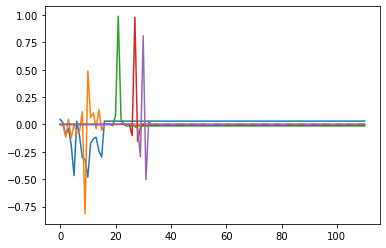

In [ ]:
plt.plot(out)

In [54]:
drafts.shape

(111, 111)